# [GN-4] Korea to English Translator

- Attention Seq2Seq를 이용하여 한영 번역기 구현
- 한국어 전처리기 작성(구두점, 대소문자, 띄어쓰기, 한글 형태소 분석 등)
- seq2seq 안정적 훈련
- 정답과 유사한 번역의 품질

라이브러리 버전 확인

In [1]:
import pandas as pd
import tensorflow as tf
import matplotlib as plt
import numpy as np
import re
import os
from os.path import join

from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings(action='ignore')


print(pd.__version__)
print(tf.__version__)
print(plt.__version__)

2.0.1
2.9.0
3.7.1


## Step 1. 데이터 다운로드

In [2]:
data_dir = "./korean_english"
def load_file(file_name):
    with open(data_dir+'/{}'.format(file_name), "r") as f:
        raw = f.read().splitlines()

    print("Data Size:", len(raw))
    print("Example:")

    for sen in raw[0:100][::20]: 
        print(">>", sen)
    
    return raw

In [3]:
ko_raw = load_file('korean-english-park.train.ko')

print('total data size:', len(ko_raw))

Data Size: 94123
Example:
>> 개인용 컴퓨터 사용의 상당 부분은 "이것보다 뛰어날 수 있느냐?"
>> 북한의 핵무기 계획을 포기하도록 하려는 압력이 거세지고 있는 가운데, 일본과 북한의 외교관들이 외교 관계를 정상화하려는 회담을 재개했다.
>> "경호 로보트가 침입자나 화재를 탐지하기 위해서 개인적으로, 그리고 전문적으로 사용되고 있습니다."
>> 수자원부 당국은 논란이 되고 있고, 막대한 비용이 드는 이 사업에 대해 내년에 건설을 시작할 계획이다.
>> 또한 근력 운동은 활발하게 걷는 것이나 최소한 20분 동안 뛰는 것과 같은 유산소 활동에서 얻는 운동 효과를 심장과 폐에 주지 않기 때문에, 연구학자들은 근력 운동이 심장에 큰 영향을 미치는지 여부에 대해 논쟁을 해왔다.
total data size: 94123


In [4]:
en_raw = load_file('korean-english-park.train.en')

print('total data size:', len(en_raw))

Data Size: 94123
Example:
>> Much of personal computing is about "can you top this?"
>> Amid mounting pressure on North Korea to abandon its nuclear weapons program Japanese and North Korean diplomats have resumed talks on normalizing diplomatic relations.
>> “Guard robots are used privately and professionally to detect intruders or fire,” Karlsson said.
>> Authorities from the Water Resources Ministry plan to begin construction next year on the controversial and hugely expensive project.
>> Researchers also have debated whether weight-training has a big impact on the heart, since it does not give the heart and lungs the kind of workout they get from aerobic activities such as brisk walking or running for at least 20 minutes.
total data size: 94123


## STEP2.Data Cleasing

In [5]:
dup_word_index = []
unique_sen = set()
i = 0
for sen in ko_raw[:]:
    if sen not in unique_sen:
        unique_sen.add(sen)
    else:
        dup_word_index.append(i)
    i +=1

print('dup_word_index 갯수: ',len(dup_word_index), 'unique_sen 갯수: ', len(unique_sen))

ko_raw = np.delete(ko_raw, dup_word_index).tolist()
en_raw = np.delete(en_raw, dup_word_index).tolist()

print('ko_raw 갯수: ',len(ko_raw), 'en_raw 갯수: ', len(en_raw))

dup_word_index 갯수:  16532 unique_sen 갯수:  77591
ko_raw 갯수:  77591 en_raw 갯수:  77591


In [6]:
dup_word_index = []
unique_sen = set()

cleaned_corpus = []

i = 0
for sen in ko_raw[:]:
    if sen not in unique_sen:
        unique_sen.add(sen)
        cleaned_corpus.append(sen + ' \t ' + en_raw[i] )
    i +=1

In [7]:
cleaned_corpus[200:205]

['그러나 북한 관리들은 그 요구를 거부했다. \t North Korean officials, however, refused that demand.',
 '그리고 미국은 사찰관들이 북한의 핵 시설을 조사하는 것을 허용하지 않겠다는 북한의 거부는 "실망스러운" 것이라고 평가했지만, 북한 측이 핵 무기 개발 계획을 포기하도록 설득하기 위해 동맹국들과 계속 협력해 나갈 것이라고 했다. \t And the United States has called North Korea\'s refusal to allow inspectors into its nuclear facilities it will continue to work with allies to convince Pyongyang to give up its nuclear weapons program.',
 '카페인은 원래 커피에 들어있는 물질이다. \t Caffeine is a substance naturally found in coffee.',
 '카페인이 제거된 커피는 카페인이 없는 커피 또는 "디카프"라고 불리워진다. \t When caffeine is removed from coffee it is called decaffeinated coffee or “decaf.”',
 '류마티스성 관절염은 뼈가 연결되는 부위인 관절을 둘러싸고 있는 조직을 신체의 면역 체계가 공격하는 질병이다. \t Rheumatoid arthritis is a disease in which the body’s defense system attacks the tissue surrounding the joints, the places where bones are joined.']

In [8]:
len(cleaned_corpus)

77591

데이타전처리

In [9]:

def preprocess_sentence(sentence, s_token=False, e_token=False):
    
    sentence = sentence.lower().strip()
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    sentence = re.sub(r"[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z0-9]+", " ", sentence)
    sentence = sentence.strip()

    if s_token:
        sentence = '<start> ' + sentence

    if e_token:
        sentence += ' <end>'
    
    return sentence

print("슝~")

슝~


In [10]:
kor_corpus = []
eng_corpus = []


mecab=Mecab('C:\mecab\mecab-ko-dic')

for pair in cleaned_corpus[:]:
    kor, eng = pair.split("\t")
    
    pre_kor = preprocess_sentence(kor)
    pre_kor = mecab.morphs(pre_kor)
    pre_eng = preprocess_sentence(eng, s_token=True, e_token=True)
    pre_eng = pre_eng.split()
    
    if len(pre_kor)<=40:  # 토큰 40이하만
        kor_corpus.append(pre_kor)
        eng_corpus.append(pre_eng)


print("Korean:", kor_corpus[120])   
print("English:", eng_corpus[120])   

Korean: ['이것', '은', '스스로', '균형', '을', '잡', '으며', '사람', '을', '실', '어', '나르', '는', '세계', '최초', '의', '운송', '수단', '입니다']
English: ['<start>', 'this', 'is', 'the', 'world', 's', 'first', 'self', 'balancing', 'human', 'transporter', 'kamen', 'said', '<end>']


In [12]:
len(kor_corpus),len(eng_corpus)

(65760, 65760)

## STEP3.토큰화

In [13]:

vocab_size=20000

def tokenize(corpus):
    
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', oov_token="<unk>", num_words=vocab_size)

    tokenizer.fit_on_texts(corpus)
    tensor = tokenizer.texts_to_sequences(corpus)       
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
    
    return tensor, tokenizer

In [14]:
enc_tensor, enc_tokenizer = tokenize(kor_corpus)
dec_tensor, dec_tokenizer = tokenize(eng_corpus)

print("Korean Vocab Size:", len(enc_tokenizer.index_word))
print("English Vocab Size:", len(dec_tokenizer.index_word))

enc_train = enc_tensor
dec_train = dec_tensor


print('enc_tensor.shape',enc_tensor.shape , 'dec_tensor.shape',dec_tensor.shape)

Korean Vocab Size: 47210
English Vocab Size: 41729
enc_tensor.shape (65760, 40) dec_tensor.shape (65760, 80)


## STEP4. 모델 설계

In [15]:
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.w_dec = tf.keras.layers.Dense(units)
        self.w_enc = tf.keras.layers.Dense(units)
        self.w_com = tf.keras.layers.Dense(1)
    
    def call(self, h_enc, h_dec):
        # h_enc shape: [batch x length x units]
        # h_dec shape: [batch x units]

        h_enc = self.w_enc(h_enc)
        h_dec = tf.expand_dims(h_dec, 1)
        h_dec = self.w_dec(h_dec)

        score = self.w_com(tf.nn.tanh(h_dec + h_enc))
        
        attn = tf.nn.softmax(score, axis=1)

        context_vec = attn * h_enc
        context_vec = tf.reduce_sum(context_vec, axis=1)

        return context_vec, attn

print("슝~")

슝~


In [16]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units):
        super(Encoder, self).__init__()
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(enc_units, dropout=0.2, return_sequences=True)

    def call(self, x):
        x = self.embedding(x)
        output = self.gru(x)
        return output

In [17]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units):
        super(Decoder, self).__init__()
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(dec_units,
                                       dropout=0.2,
                                       return_sequences=True,
                                       return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.dec_units)

    def call(self, x, h_dec, enc_out):
        context_vec, attn = self.attention(enc_out, h_dec)
        

        out = self.embedding(x)
        out = tf.concat([tf.expand_dims(context_vec, 1), out], axis=-1)
        
        out, h_dec = self.gru(out)
        out = tf.reshape(out, (-1, out.shape[2]))
        out = self.fc(out)

        return out, h_dec, attn

In [18]:
# 코드를 실행하세요.

BATCH_SIZE     = 64
# SRC_VOCAB_SIZE = len(enc_tokenizer.index_word) + 1
# TGT_VOCAB_SIZE = len(dec_tokenizer.index_word) + 1

SRC_VOCAB_SIZE = vocab_size
TGT_VOCAB_SIZE = vocab_size

print('SRC_VOCAB_SIZE',SRC_VOCAB_SIZE)
print('TGT_VOCAB_SIZE',TGT_VOCAB_SIZE)

units         = 128
embedding_dim = 128

encoder = Encoder(SRC_VOCAB_SIZE, embedding_dim, units)
decoder = Decoder(TGT_VOCAB_SIZE, embedding_dim, units)

# sample input
sequence_len = 40

sample_enc = tf.random.uniform((BATCH_SIZE, sequence_len))
sample_output = encoder(sample_enc)

print ('Encoder Output:', sample_output.shape)

sample_state = tf.random.uniform((BATCH_SIZE, units))

sample_logits, h_dec, attn = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                     sample_state, sample_output)

print ('Decoder Output:', sample_logits.shape)
print ('Decoder Hidden State:', h_dec.shape)
print ('Attention:', attn.shape)

SRC_VOCAB_SIZE 20000
TGT_VOCAB_SIZE 20000
Encoder Output: (64, 40, 128)
Decoder Output: (64, 20000)
Decoder Hidden State: (64, 128)
Attention: (64, 40, 1)


Optimizer & Loss

In [19]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss = loss_object(real, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask
    
    return tf.reduce_mean(loss)

print("슝~")

슝~


## STEP5.train_step 구현하기

In [20]:
@tf.function
def train_step(src, tgt, encoder, decoder, optimizer, dec_tok):
    bsz = src.shape[0]
    loss = 0

    with tf.GradientTape() as tape:
        enc_out = encoder(src)
        h_dec = enc_out[:, -1]
        
        dec_src = tf.expand_dims([dec_tok.word_index['<start>']] * bsz, 1)

        for t in range(1, tgt.shape[1]):
            pred, h_dec, _ = decoder(dec_src, h_dec, enc_out)

            loss += loss_function(tgt[:, t], pred)
            dec_src = tf.expand_dims(tgt[:, t], 1)
        
    batch_loss = (loss / int(tgt.shape[1]))

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))
    
    return batch_loss

print("슝~")

슝~


In [22]:
from tqdm import tqdm    # tqdm
import random

EPOCHS = 20

for epoch in range(EPOCHS):
    total_loss = 0
    
    idx_list = list(range(0, enc_train.shape[0], BATCH_SIZE))
    random.shuffle(idx_list)
    t = tqdm(idx_list)    # tqdm

    for (batch, idx) in enumerate(t):
        batch_loss = train_step(enc_train[idx:idx+BATCH_SIZE],
                                dec_train[idx:idx+BATCH_SIZE],
                                encoder,
                                decoder,
                                optimizer,
                                dec_tokenizer)
    
        total_loss += batch_loss
        
        t.set_description_str('Epoch %2d' % (epoch + 1))    # tqdm
        t.set_postfix_str('Loss %.4f' % (total_loss.numpy() / (batch + 1)))    # tqdm

Epoch 20: 100%|██████████| 1028/1028 [04:40<00:00,  3.66it/s, Loss 1.0787]


In [23]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.rcParams["font.family"] = "NanumGothic"
 
%config InlineBackend.figure_format = 'retina'

In [24]:
def evaluate(sentence, encoder, decoder):
    attention = np.zeros((dec_train.shape[-1], enc_train.shape[-1]))
    
    sentence = preprocess_sentence(sentence)
    mecab_sentence = mecab.morphs(sentence)

    inputs = enc_tokenizer.texts_to_sequences([mecab_sentence])

    inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                           maxlen=enc_train.shape[-1],
                                                           padding='post')

    result = ''

    enc_out = encoder(inputs)

    dec_hidden = enc_out[:, -1]
    dec_input = tf.expand_dims([dec_tokenizer.word_index['<start>']], 0)

    i = 0
    for t in range(dec_train.shape[-1]):

        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

       
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention[t] = attention_weights.numpy()

        predicted_id = tf.argmax(tf.math.softmax(predictions, axis=-1)[0]).numpy()
    
        
        result += dec_tokenizer.index_word[predicted_id] + ' '

        if dec_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention

        dec_input = tf.expand_dims([predicted_id], 0)
        i +=1

    return result, sentence, attention


def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')

    fontdict = {'fontsize': 14}

    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def translate(sentence, encoder, decoder):
    result, sentence, attention = evaluate(sentence, encoder, decoder)
   

    print('Input: %s' % (sentence))
    print('Predicted translation: {}'.format(result))
    
    #attention = attention[:len(result), :len(sentence)]

    

    attention = attention[:len(result.split()), :len(sentence.split())]
    plot_attention(attention, sentence.split(), result.split(' '))




In [52]:
enc_sentence = [
    '오바마는 대통령이다.',
    '시민들은 도시 속에 산다.',
    '커피는 필요없다.',
    '일곱 명의 사망자가 발생했다.',
    '지금은 오후 9시다.',
    '병원에 환자가 많다.',
    '여름 캠프에 가기로 했다.',
    '날씨가 벌써 덥고 건조하다.'
]


dec_sentence = []

for sen in enc_sentence:
    #print('enc_sen:',sen)
    result, dec_sen, attention = evaluate(sen, encoder, decoder)
    #print('result:',result)
    dec_sentence.append(result)

i = 0                        
for sen in enc_sentence:
    print('K{}:'.format(i)+sen)
    i +=1

print('---------------------')
i = 0   
for sen in dec_sentence:
    print('E{}:'.format(i)+sen)
    i +=1


K0:오바마는 대통령이다.
K1:시민들은 도시 속에 산다.
K2:커피는 필요없다.
K3:일곱 명의 사망자가 발생했다.
K4:지금은 오후 9시다.
K5:병원에 환자가 많다.
K6:여름 캠프에 가기로 했다.
K7:날씨가 벌써 덥고 건조하다.
---------------------
E0:obama s senator is to be a new york senator <end> 
E1:people are <unk> <end> 
E2:the weather is not going to be a lot of your job <end> 
E3:two men were injured <end> 
E4:now is the first time <end> 
E5:a hospital <end> 
E6:it s not to be a little in the next day <end> 
E7:the weather is down <end> 


Input: 오바마는 대통령이다
Predicted translation: obama s senator is to be a new york senator <end> 


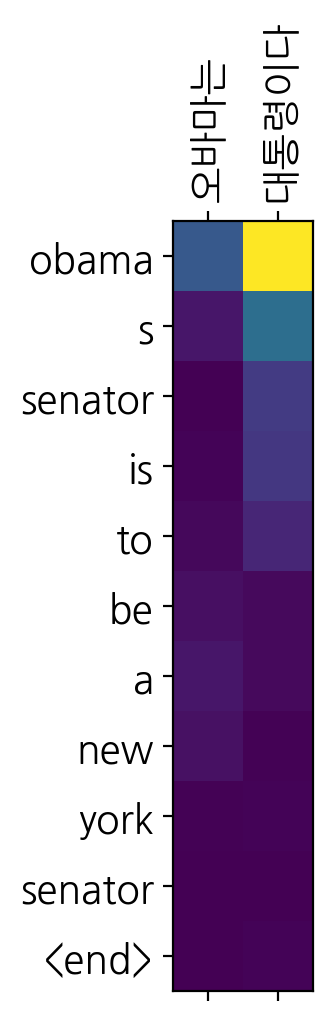

In [33]:
translate("오바마는 대통령이다.", encoder, decoder)

Input: 시민들은 도시 속에 산다
Predicted translation: the homeless will be the <unk> <end> 


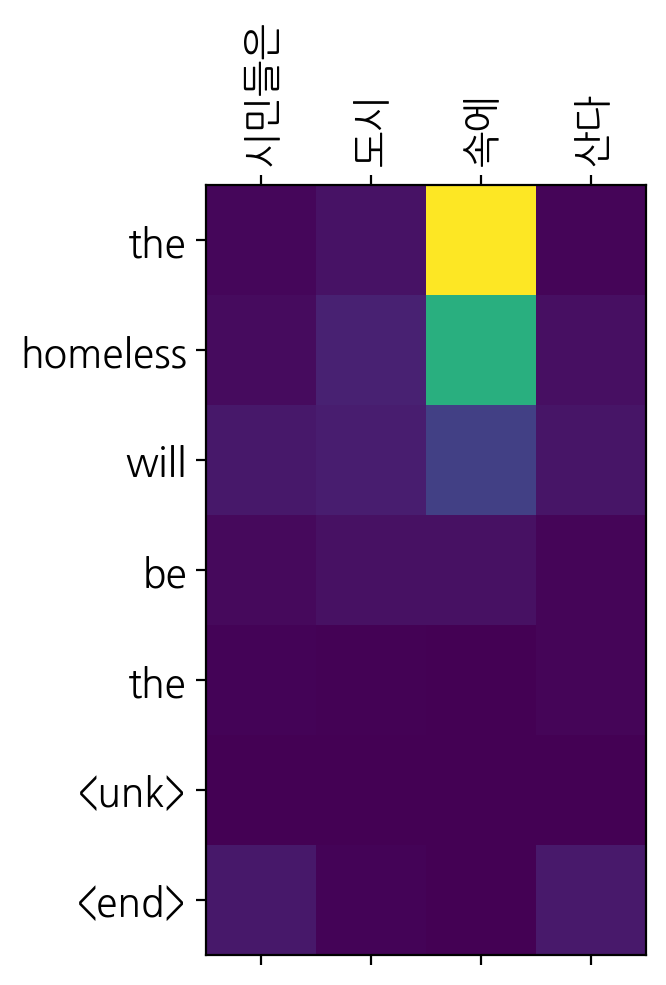

In [ ]:
translate("시민들은 도시 속에 산다.", encoder, decoder)

Input: 커피는 필요없다
Predicted translation: what s not a good thing <end> 


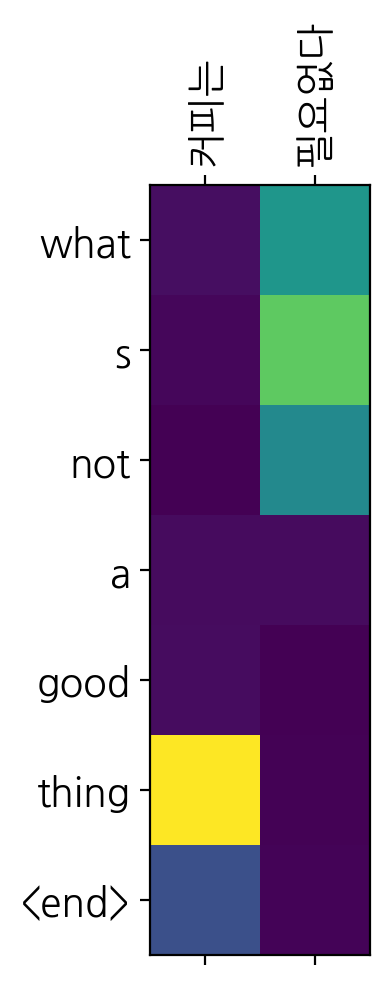

In [ ]:
translate("커피는 필요없다.", encoder, decoder)

Input: 일곱 명의 사망자가 발생했다
Predicted translation: two men were injured <end> 


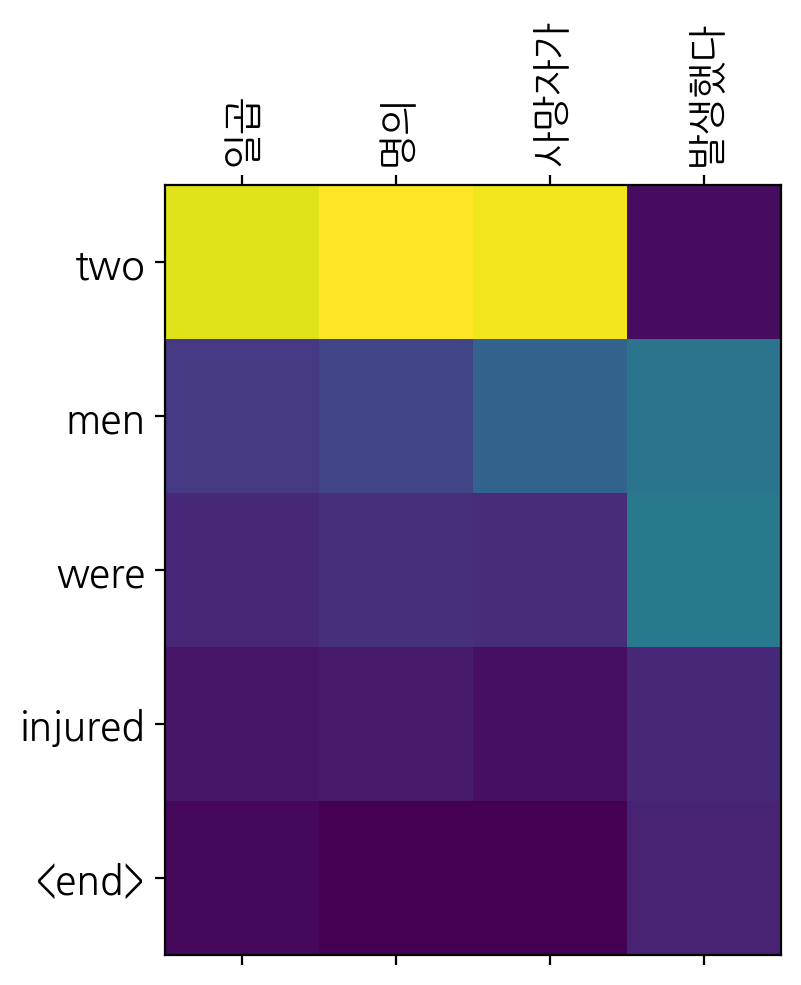

In [34]:
translate("일곱 명의 사망자가 발생했다.", encoder, decoder)

Input: 지금은 오후 9시다
Predicted translation: now is the first time <end> 


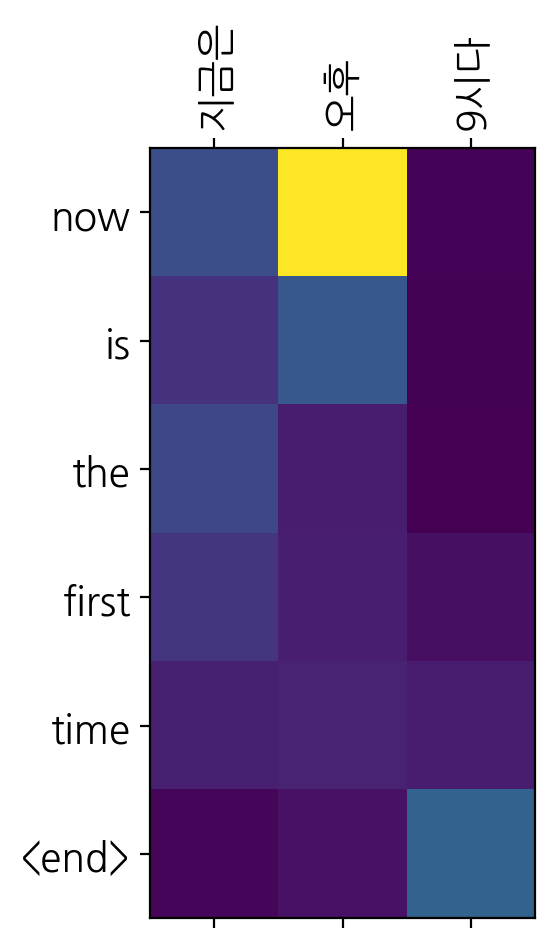

In [40]:
translate("지금은 오후 9시다.", encoder, decoder)

Input: 병원에 환자가 많다
Predicted translation: a hospital <end> 


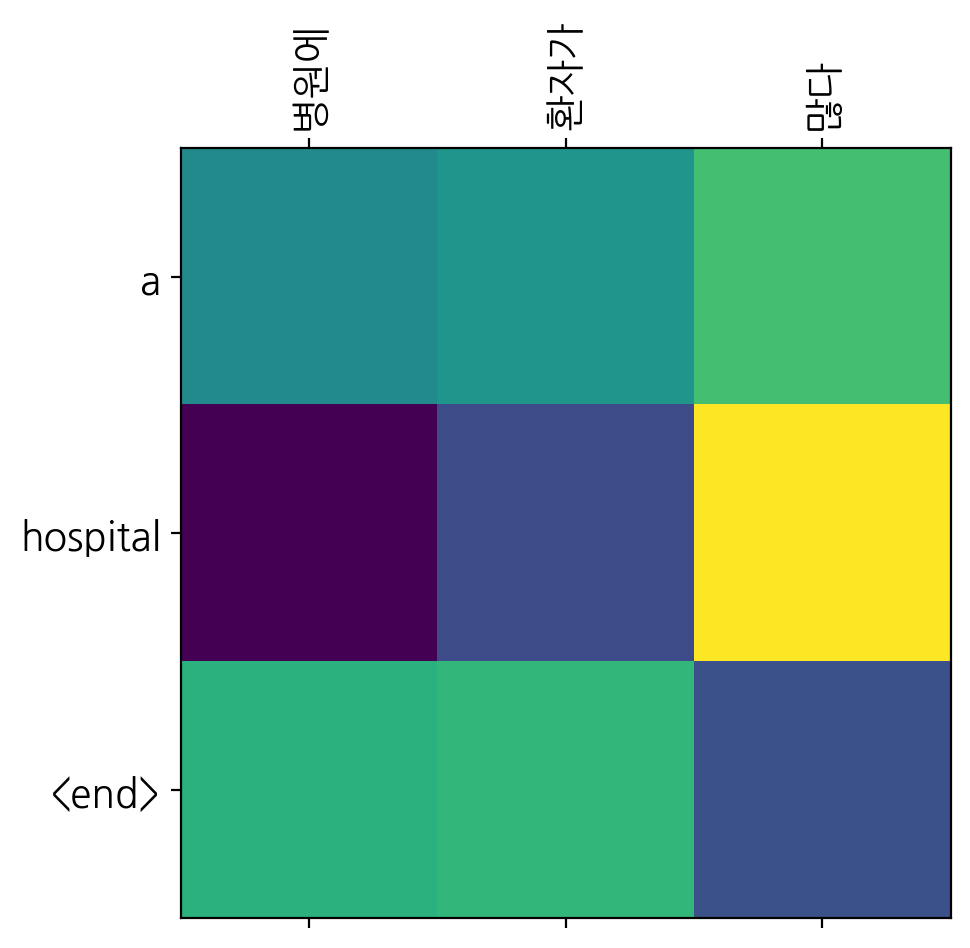

In [48]:
translate("병원에 환자가 많다.", encoder, decoder)

Input: 병원에 환자가 많다
Predicted translation: a hospital <end> 


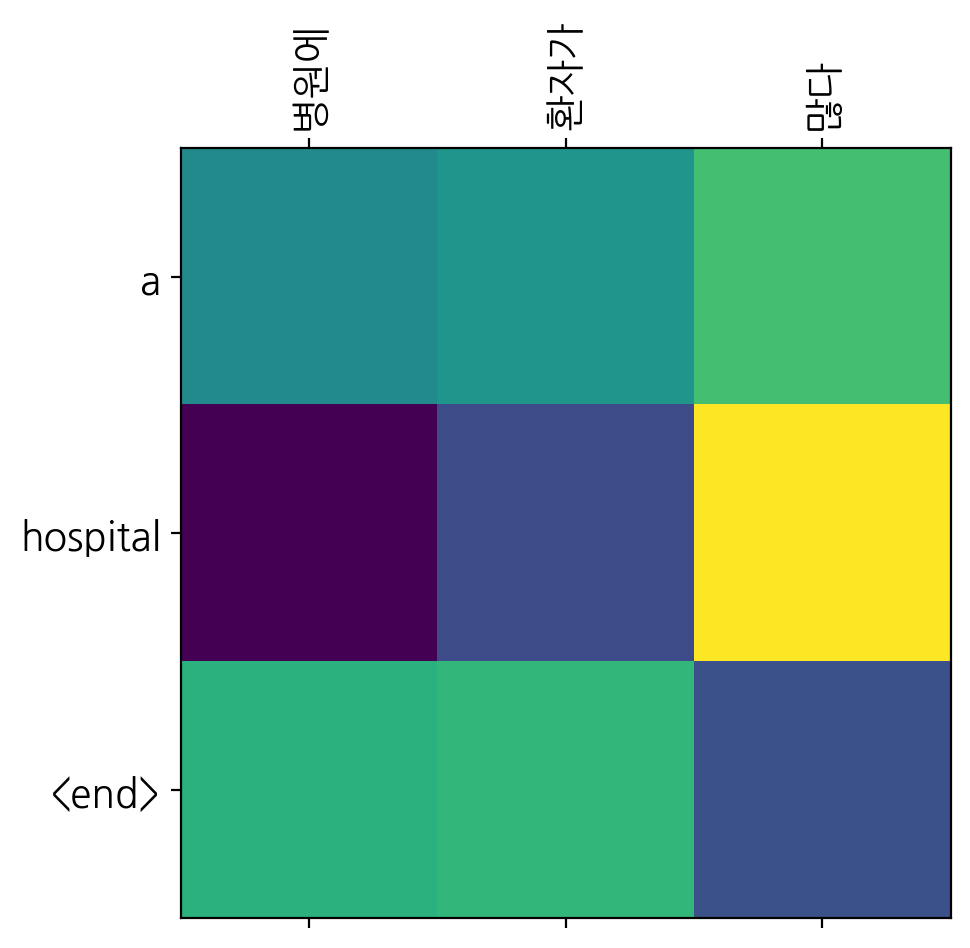

In [53]:
translate("병원에 환자가 많다.", encoder, decoder)

Input: 여름 캠프에 가기로 했다
Predicted translation: it s not to be a little in the next day <end> 


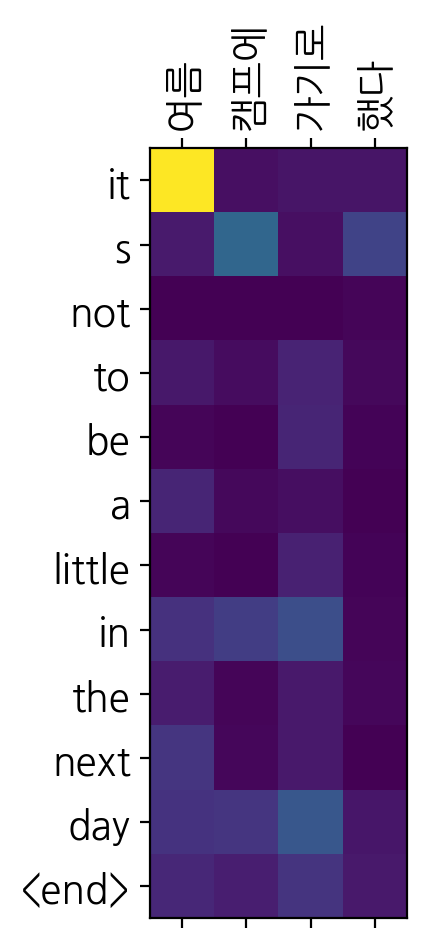

In [51]:
translate("여름 캠프에 가기로 했다.", encoder, decoder)

# 회고

- 데이타의 중복을 제거하고, 한국어와 영어를 쌍으로 유지하도록 하는데 Dataframe을 쓸까 하다가 새로운 방법으로 도전해 봤다. 
- Seq2Seq 로 encoder, decoder를 구성하며, BahdanauAttention로 Attention을 구성했다. 
- 번역의 품질이 그다지 좋지 않아서 여러가지를 vocab_size를 늘려보며 시도해 보았지만, 크게 나아지지는 않았다. 
<img src='https://user-images.githubusercontent.com/95423215/244850786-81a51aae-2f20-43fe-935c-4b86d9e02d11.png'>
